<a href="https://colab.research.google.com/github/XiaoPeng-Zhang/Feature-Engineering-Made-Easy-Note/blob/master/Airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline
import datetime
import os
import seaborn as sns#数据可视化
from datetime import date
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
import pickle #用于存储模型
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import *

In [0]:
test=pd.read_csv('test_users.csv')
train=pd.read_csv('train_users_2.csv')

In [0]:
'''
分析：

train文件比test文件多了特征-country_destination
country_destination是需要预测的目标变量
数据探索时着重分析train文件，test文件类似
'''
print("the columm of the test\n",test.columns)
print("the columm of the train\n",train.columns)

the columm of the test
 Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser'],
      dtype='object')
the columm of the train
 Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')


In [0]:
'''
分析：

trian文件包含213451行数据，16个特征
每个特征的数据类型和非空数值
date_first_booking空值较多，在特征提取时可以考虑删除
'''
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB
None


In [0]:
'''
特征分析：
1. date_account_created
'''
#统计
print(train.date_account_created.value_counts().head())
print(train.date_account_created.value_counts().tail())
#获取date_account_created信息
print("\ndescribe\n")
print(train.date_account_created.describe())

2014-05-13    674
2014-06-24    670
2014-06-25    636
2014-05-20    632
2014-05-14    622
Name: date_account_created, dtype: int64
2010-04-01    1
2010-06-18    1
2010-04-11    1
2010-04-24    1
2010-02-14    1
Name: date_account_created, dtype: int64

describe

count         213451
unique          1634
top       2014-05-13
freq             674
Name: date_account_created, dtype: object


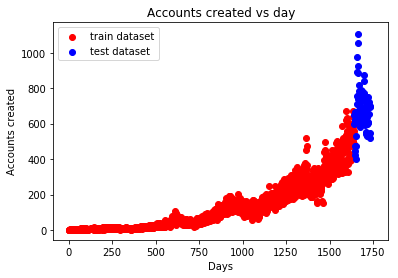

In [0]:
#观察用户增长情况
da_train=train.date_account_created.value_counts()
da_test=test.date_account_created.value_counts()
#将数据类型转换为DateTime类型
da_train_date=pd.to_datetime(train.date_account_created.value_counts().index)
da_test_date=pd.to_datetime(test.date_account_created.value_counts().index)
#计算离首次注册日期相差天数
da_train_day=da_train_date-da_train_date.min()
da_test_day=da_test_date-da_train_date.min()
#用matplotlib作图
plt.scatter(da_train_day.days,da_train.values,color = 'r', label = 'train dataset')
plt.scatter(da_test_day.days,da_test.values,color='b',label='test dataset')

plt.title("Accounts created vs day")
plt.xlabel("Days")
plt.ylabel("Accounts created")
plt.legend(loc = 'upper left')
'''
分析：

x轴：离首次注册时间相差的天数
y轴：当天注册的用户数量
随着时间的增长,用户注册的数量在急剧上升
'''


In [0]:
#2. timestamp_first_active
print(train.timestamp_first_active.value_counts().unique())
'''
分析： 结果[1]表明timestamp_first_active没有重复数据
'''

[1]


In [0]:
tfa_train_dt = train.timestamp_first_active.astype(str).apply(lambda x:  
                                                                    datetime.datetime(int(x[:4]),
                                                                                      int(x[4:6]), 
                                                                                      int(x[6:8]), 
                                                                                      int(x[8:10]), 
                                                                                      int(x[10:12]),
                                                                                      int(x[12:])))
print(tfa_train_dt.describe())

count                  213451
unique                 213451
top       2013-07-01 05:26:34
freq                        1
first     2009-03-19 04:32:55
last      2014-06-30 23:58:24
Name: timestamp_first_active, dtype: object


In [0]:
#3. date_first_booking
print(train.date_first_booking.describe())
print(test.date_first_booking.describe())
'''
分析：

train文件中date_first_booking有大量缺失值
test文件中date_first_booking全是缺失值
可以删除特征date_first_booking
'''

count          88908
unique          1976
top       2014-05-22
freq             248
Name: date_first_booking, dtype: object
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: date_first_booking, dtype: float64


Text(0, 0.5, 'counts')

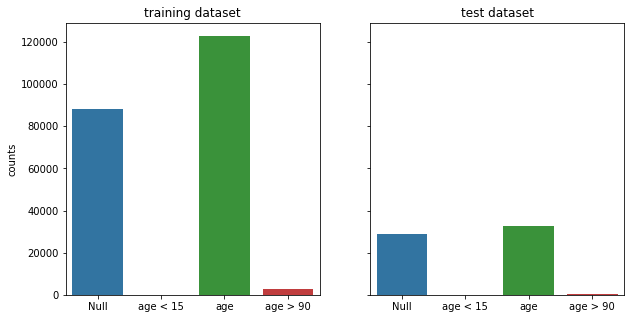

In [0]:
#4.age
#柱状图分析
##首先将年龄进行分成4组missing values, too small age, reasonable age, too large age
train_age=[train[train.age.isnull()].age.shape[0]
           ,train.query('age<15').age.shape[0]
           ,train.query('age>=15&age<=90').age.shape[0]
           ,train.query('age>90').age.shape[0]
          ]

test_age=[test[test.age.isnull()].age.shape[0]
           ,test.query('age<15').age.shape[0]
           ,test.query('age>=15&age<=90').age.shape[0]
           ,test.query('age>90').age.shape[0]
          ]

columns = ['Null', 'age < 15', 'age', 'age > 90']

# plot
fig, (ax1,ax2) = plt.subplots(1,2,sharex=True, sharey = True,figsize=(10,5))

sns.barplot(columns, train_age, ax = ax1)
sns.barplot(columns, test_age, ax = ax2)

ax1.set_title('training dataset')
ax2.set_title('test dataset')
ax1.set_ylabel('counts')
#分析：异常年龄较少，且有一定数量的缺失值

In [0]:
def feature_barplot(feature, df_train = train, df_test = test, figsize=(10,5), rot = 90, saveimg =False):
  